In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_participants
from hmpai.pytorch.utilities import set_global_seed
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.pytorch.normalization import *
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.pytorch.training import train_and_test
import matplotlib.pyplot as plt
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# Load in t1, t2 and cmb
t1_path = DATA_PATH / "prp/stage_data_250hz_t1.nc"
t2_path = DATA_PATH / "prp/stage_data_250hz_t2.nc"
cmb_path = DATA_PATH / "prp/VP_all_trial_250_off50.nc"

t1 = xr.open_dataset(t1_path)
t2 = xr.open_dataset(t2_path)
cmb = xr.open_dataset(cmb_path)

In [3]:
SHORT_DELAY = 300 #ms
LONG_DELAY = 1200 #ms
SAMPLING_FREQUENCY = 250 #hz

SHORT_PADDING = int((SHORT_DELAY / 1000) * SAMPLING_FREQUENCY)
LONG_PADDING = int((LONG_DELAY / 1000) * SAMPLING_FREQUENCY)

In [4]:
# Check if t1 and t2 align
# Manually adjust vertical to correct for baseline referencing
# Use this to figure out delay
def plot_epoch(epoch, delay, vertical=0):
    t1_data = t1.sel(participant='VP10', epochs=epoch, channels='Fp1')
    t2_data = t2.sel(participant='VP10', epochs=epoch, channels='Fp1')
    cmb_data = cmb.sel(participant='VP10', epochs=epoch, channels='Fp1')
    plt.title(f"{t1_data.condition.item()}, {t2_data.condition.item()}, {cmb_data.condition.item()}")
    plt.plot(cmb_data.data, label='cmb')
    plt.plot(t1_data.data, label='t1')
    plt.plot(range(delay, len(t2_data.samples) + delay), t2_data.data + vertical, label='t2')
    plt.legend()
    plt.show()

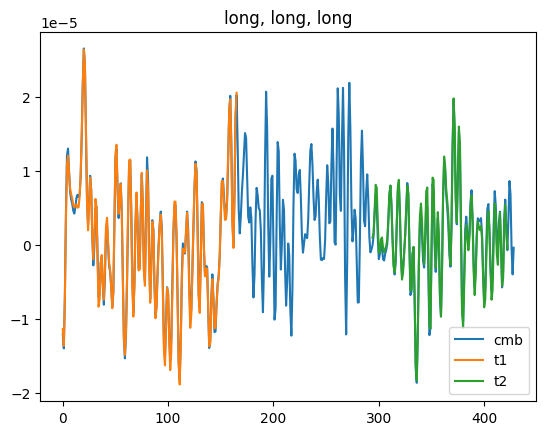

In [ ]:
# Lines up with CMB, LONG_PADDING is -6
plot_epoch(1, LONG_PADDING - 6, vertical=0.0000070)

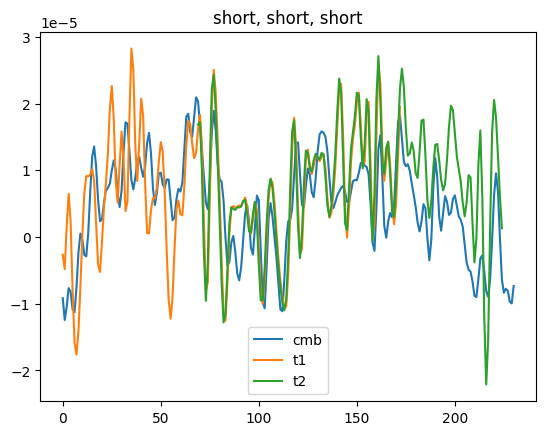

In [64]:
# Lines up with t1, SHORT PADDING is 6 less
plot_epoch(2, SHORT_PADDING - 6, 0.000007)

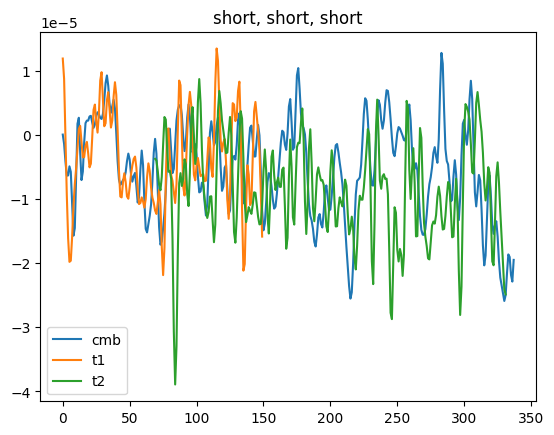

In [8]:
# Doesn't line up with t1
plot_epoch(75, SHORT_PADDING - 6, vertical=-0.0000070)
